In [ ]:
# this code is based on: Bingchen Liu, Yizhe Zhu, Kunpeng Song, Ahmed Elgammal. A Fast and Stable GAN for Small and High Resolution Imagesets - 
# pytorch. url: https://github.com/odegeasslbc/FastGAN-pytorch. (accessed 06.02.2022), which is released under the GNU liscence
# the file vgg.pth was downloaded from this github repository and placed in folder weights/v0.1 in this file's directory 
# these are weights for a pre-trained model used as part of perceptual loss function that is a measure of difference between images, NOT for G or D

# with dual contrastive loss as implemented in: Phil Wang. 'Lightweight' GAN. url: https://github.com/lucidrains/lightweight-gan. 
# (accessed 06.02.2022) which is released under the MIT liscence

# FFHQ thumbnail dataset was taken from:
# Janne Hellsten. Flickr-Faces-HQ Dataset (FFHQ). github url: https://github.com/NVlabs/ffhq-dataset. google drive url with images:
# https://drive.google.com/drive/folders/1tg-Ur7d4vk1T8Bn0pPpUSQPxlPGBlGfv. (accessed 06.02.2022) which is released under the Creative Commons 
# BY-NC-SA 4.0 license by NVIDIA Corporation
# this dataset was zipped and placed in the folder ffhq in the same directory as this file


# imports
!pip install einops
from einops import rearrange, repeat
import random
import os
from collections import namedtuple
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.io import read_image
from PIL import Image
import glob
import matplotlib.pyplot as plt

# hyperparameters
# multipliers to figure out number of channels
ndf = 64
ngf = 64
#size of latent vector
nz = 256 
img_height = 128
img_width = 128
batch_size  = 16
n_channels  = 3
latent_size = 512
my_dataset = 'ffhq'
lr = 0.0002
betas = (0.5, 0.999)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# optional Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
os.mkdir("/tmp/ffhq")
raven_zip = zipfile.ZipFile("drive/My Drive/Colab Notebooks/DL and RL/DL coursework/ffhq/thumbnails128x128.zip", "r")
raven_zip.extractall("/tmp/ffhq")
raven_zip = zipfile.ZipFile("drive/My Drive/Colab Notebooks/DL and RL/DL coursework/ffhq/thumbnails128x128-002.zip", "r")
raven_zip.extractall("/tmp/ffhq")

In [ ]:
# ffhq dataset processing code

def round_down(num, divisor):
    return num - (num%divisor)

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class CustomImageDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)), transforms.ToTensor()
            , transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

    def __len__(self):
        return 70000 

    def __getitem__(self, idx):
        folder = str(round_down(idx, 1000))
        idx = str(idx)
        while len(folder) < 5:
            folder = "0" + folder
        while len(idx) < 5:
            idx = "0" + idx
        img_path = self.img_dir + "/" + folder + "/" + idx + ".png"
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

dataset = CustomImageDataset("/tmp/ffhq/thumbnails128x128")

train_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=True)
train_iterator = iter(cycle(train_loader))

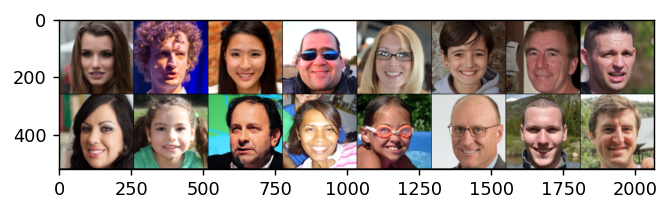

In [ ]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 128
x = next(train_iterator)
x = x.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x.add(1).mul(0.5)).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

**Define a FastGAN**

In [ ]:
seq = nn.Sequential

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            m.weight.data.normal_(0.0, 0.02)
        except:
            pass
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def conv2d(*args, **kwargs):
    return spectral_norm(nn.Conv2d(*args, **kwargs))

def convTranspose2d(*args, **kwargs):
    return spectral_norm(nn.ConvTranspose2d(*args, **kwargs))

def batchNorm2d(*args, **kwargs):
    return nn.BatchNorm2d(*args, **kwargs)

def linear(*args, **kwargs):
    return spectral_norm(nn.Linear(*args, **kwargs))

class PixelNorm(nn.Module):
    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

class Reshape(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.target_shape = shape

    def forward(self, feat):
        batch = feat.shape[0]
        return feat.view(batch, *self.target_shape)        


class GLU(nn.Module):
    def forward(self, x):
        nc = x.size(1)
        assert nc % 2 == 0, 'channels dont divide 2!'
        nc = int(nc/2)
        return x[:, :nc] * torch.sigmoid(x[:, nc:])


class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1), requires_grad=True)

    def forward(self, feat, noise=None):
        if noise is None:
            batch, _, height, width = feat.shape
            noise = torch.randn(batch, 1, height, width).to(feat.device)

        return feat + self.weight * noise


class Swish(nn.Module):
    def forward(self, feat):
        return feat * torch.sigmoid(feat)


class SEBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()

        self.main = nn.Sequential(  nn.AdaptiveAvgPool2d(4), 
                                    conv2d(ch_in, ch_out, 4, 1, 0, bias=False), Swish(),
                                    conv2d(ch_out, ch_out, 1, 1, 0, bias=False), nn.Sigmoid() )

    def forward(self, feat_small, feat_big):
        return feat_big * self.main(feat_small)


class InitLayer(nn.Module):
    def __init__(self, nz, channel):
        super().__init__()

        self.init = nn.Sequential(
                        convTranspose2d(nz, channel*2, 4, 1, 0, bias=False),
                        batchNorm2d(channel*2), GLU() )

    def forward(self, noise):
        noise = noise.view(noise.shape[0], -1, 1, 1)
        return self.init(noise)


def UpBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv2d(in_planes, out_planes*2, 3, 1, 1, bias=False),
        batchNorm2d(out_planes*2), GLU())
    return block


def UpBlockComp(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv2d(in_planes, out_planes*2, 3, 1, 1, bias=False),
        NoiseInjection(),
        batchNorm2d(out_planes*2), GLU(),
        conv2d(out_planes, out_planes*2, 3, 1, 1, bias=False),
        NoiseInjection(),
        batchNorm2d(out_planes*2), GLU()
        )
    return block


class Generator(nn.Module):
    def __init__(self, ngf=64, nz=100, nc=3, im_size=1024):
        super(Generator, self).__init__()

        nfc_multi = {4:16, 8:8, 16:4, 32:2, 64:2, 128:1, 256:0.5, 512:0.25, 1024:0.125}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v*ngf)

        self.im_size = im_size

        self.init = InitLayer(nz, channel=nfc[4])
                                
        self.feat_8   = UpBlockComp(nfc[4], nfc[8])
        self.feat_16  = UpBlock(nfc[8], nfc[16])
        self.feat_32  = UpBlockComp(nfc[16], nfc[32])
        self.feat_64  = UpBlock(nfc[32], nfc[64])
        self.feat_128 = UpBlockComp(nfc[64], nfc[128])  
        self.feat_256 = UpBlock(nfc[128], nfc[256]) 

        self.se_32  = SEBlock(nfc[4], nfc[32]) #self.se_64  = SEBlock(nfc[4], nfc[64])
        self.se_64  = SEBlock(nfc[8], nfc[64]) #self.se_128 = SEBlock(nfc[8], nfc[128])
        self.se_128 = SEBlock(nfc[16], nfc[128]) #self.se_256 = SEBlock(nfc[16], nfc[256])

        self.to_64 = conv2d(nfc[64], nc, 1, 1, 0, bias=False) #self.to_128 = conv2d(nfc[128], nc, 1, 1, 0, bias=False) 
        self.to_big = conv2d(nfc[im_size], nc, 3, 1, 1, bias=False) 
        
    def forward(self, input):
        
        feat_4   = self.init(input)
        feat_8   = self.feat_8(feat_4)
        feat_16  = self.feat_16(feat_8)
        
        feat_32 = self.se_32(feat_4, self.feat_32(feat_16))
        
        feat_64 = self.se_64(feat_8, self.feat_64(feat_32))

        feat_128 = self.se_128(feat_16, self.feat_128(feat_64))

        #feat_256 = self.feat_256(feat_128)

        return [self.to_big(feat_128), self.to_64(feat_64)]
        
        """feat_32  = self.feat_32(feat_16)

        feat_64  = self.se_64( feat_4, self.feat_64(feat_32) )

        feat_128 = self.se_128( feat_8, self.feat_128(feat_64) )

        feat_256 = self.se_256( feat_16, self.feat_256(feat_128) )

        return [self.to_big(feat_256), self.to_128(feat_128)]"""


class DownBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(DownBlock, self).__init__()

        self.main = nn.Sequential(
            conv2d(in_planes, out_planes, 4, 2, 1, bias=False),
            batchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, feat):
        return self.main(feat)


class DownBlockComp(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(DownBlockComp, self).__init__()

        self.main = nn.Sequential(
            conv2d(in_planes, out_planes, 4, 2, 1, bias=False),
            batchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True),
            conv2d(out_planes, out_planes, 3, 1, 1, bias=False),
            batchNorm2d(out_planes), nn.LeakyReLU(0.2)
            )

        self.direct = nn.Sequential(
            nn.AvgPool2d(2, 2),
            conv2d(in_planes, out_planes, 1, 1, 0, bias=False),
            batchNorm2d(out_planes), nn.LeakyReLU(0.2))

    def forward(self, feat):
        return (self.main(feat) + self.direct(feat)) / 2


class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=3, im_size=512):
        super(Discriminator, self).__init__()
        self.ndf = ndf
        self.im_size = im_size

        nfc_multi = {4:16, 8:16, 16:8, 32:4, 64:2, 128:1, 256:0.5, 512:0.25, 1024:0.125}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v*ndf)


        self.down_from_big = nn.Sequential( 
                                    #conv2d(nc, nfc[512], 4, 2, 1, bias=False),
                                    conv2d(nc, nfc[512], 3, 1, 1, bias=False),
                                    nn.LeakyReLU(0.2, inplace=True) )

        self.down_4  = DownBlockComp(nfc[512], nfc[256])
        self.down_8  = DownBlockComp(nfc[256], nfc[128])
        self.down_16 = DownBlockComp(nfc[128], nfc[64])
        self.down_32 = DownBlockComp(nfc[64],  nfc[32])
        self.down_64 = DownBlockComp(nfc[32],  nfc[16])

        self.rf_big = nn.Sequential(
                            #conv2d(nfc[16] , nfc[8], 1, 1, 0, bias=False),
                            #batchNorm2d(nfc[8]), nn.LeakyReLU(0.2, inplace=True),
                            DownBlockComp(nfc[16],  nfc[8]),
                            #conv2d(nfc[8], 1, 4, 1, 0, bias=False)
                            conv2d(nfc[8], 1, 2, 1, 0, bias=False)
                            )

        self.se_2_16 = SEBlock(nfc[512], nfc[64])
        self.se_4_32 = SEBlock(nfc[256], nfc[32])
        self.se_8_64 = SEBlock(nfc[128], nfc[16])
        
        self.down_from_small = nn.Sequential( 
                                            #conv2d(nc, nfc[256], 4, 2, 1, bias=False), 
                                            conv2d(nc, nfc[256], 3, 1, 1, bias=False),
                                            nn.LeakyReLU(0.2, inplace=True),
                                            DownBlock(nfc[256],  nfc[128]),
                                            DownBlock(nfc[128],  nfc[64]),
                                            DownBlock(nfc[64],  nfc[32]), )

        self.rf_small = nn.Sequential(
                            DownBlock(nfc[32],  nfc[16]),
                            conv2d(nfc[16], 1, 4, 1, 0, bias=False))

        self.decoder_big = SimpleDecoder(nfc[16], nc)
        self.decoder_small = SimpleDecoder(nfc[32], nc)
        
    def forward(self, imgs, label):
        if type(imgs) is not list:
            imgs = [F.interpolate(imgs, size=self.im_size), F.interpolate(imgs, size=64)]
        
        # 16, 3, 128x128
        feat_2 = self.down_from_big(imgs[0])
        #16, 16, 128x128
        feat_4 = self.down_4(feat_2)
        # 16, 32, 64x64
        feat_8 = self.down_8(feat_4)
        # 16, 64, 32x32
        feat_16 = self.down_16(feat_8)
        feat_16 = self.se_2_16(feat_2, feat_16)
        # 16, 128, 16x16
        feat_32 = self.down_32(feat_16)
        feat_32 = self.se_4_32(feat_4, feat_32)
        # 16, 256, 8x8
        feat_last = self.down_64(feat_32)
        feat_last = self.se_8_64(feat_8, feat_last)
        # 16, 512, 4x4

        rf_0 = self.rf_big(feat_last).view(-1)
        # 16
        feat_small = self.down_from_small(imgs[1])
        # 16, 256, 8x8
        rf_1 = self.rf_small(feat_small).view(-1)
        #16

        if label=='real':    
            rec_img_big = self.decoder_big(feat_last)
            rec_img_small = self.decoder_small(feat_small)

            if feat_32.shape[2] >= 16:
                part = random.randint(0, 3)
                rec_img_part = None
                cut = feat_32.shape[2]//2
                if part==0:
                    rec_img_part = self.decoder_part(feat_32[:,:,:cut,:cut])
                if part==1:
                    rec_img_part = self.decoder_part(feat_32[:,:,:cut,cut:])
                if part==2:
                    rec_img_part = self.decoder_part(feat_32[:,:,cut:,:cut])
                if part==3:
                    rec_img_part = self.decoder_part(feat_32[:,:,cut:,cut:])
            else:
                rec_img_part = rec_img_big
                part = 1
            return torch.cat([rf_0, rf_1]) , [rec_img_big, rec_img_small, rec_img_part], part 

        return torch.cat([rf_0, rf_1]) 


class SimpleDecoder(nn.Module):
    def __init__(self, nfc_in=64, nc=3):
        super(SimpleDecoder, self).__init__()

        nfc_multi = {4:16, 8:8, 16:4, 32:2, 64:2, 128:1, 256:0.5, 512:0.25, 1024:0.125}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v*32)

        def upBlock(in_planes, out_planes):
            block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                conv2d(in_planes, out_planes*2, 3, 1, 1, bias=False),
                batchNorm2d(out_planes*2), GLU())
            return block

        self.main = nn.Sequential(  #nn.AdaptiveAvgPool2d(8),
                                    upBlock(nfc_in, nfc[16]) ,
                                    upBlock(nfc[16], nfc[32]),
                                    upBlock(nfc[32], nfc[64]),
                                    upBlock(nfc[64], nfc[128]),
                                    conv2d(nfc[128], nc, 3, 1, 1, bias=False),
                                    nn.Tanh() )

    def forward(self, input):
        # input shape: c x 4 x 4
        return self.main(input)

from random import randint
def random_crop(image, size):
    h, w = image.shape[2:]
    ch = randint(0, h-size-1)
    cw = randint(0, w-size-1)
    return image[:,:,ch:ch+size,cw:cw+size]

class TextureDiscriminator(nn.Module):
    def __init__(self, ndf=64, nc=3, im_size=512):
        super(TextureDiscriminator, self).__init__()
        self.ndf = ndf
        self.im_size = im_size

        nfc_multi = {4:16, 8:8, 16:8, 32:4, 64:2, 128:1, 256:0.5, 512:0.25, 1024:0.125}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v*ndf)

        self.down_from_small = nn.Sequential( 
                                            conv2d(nc, nfc[256], 4, 2, 1, bias=False), 
                                            nn.LeakyReLU(0.2, inplace=True),
                                            DownBlock(nfc[256],  nfc[128]),
                                            DownBlock(nfc[128],  nfc[64]),
                                            DownBlock(nfc[64],  nfc[32]), )
        self.rf_small = nn.Sequential(
                            conv2d(nfc[16], 1, 4, 1, 0, bias=False))

        self.decoder_small = SimpleDecoder(nfc[32], nc)
        
    def forward(self, img, label):
        img = random_crop(img, size=128)

        feat_small = self.down_from_small(img)
        rf = self.rf_small(feat_small).view(-1)
        
        if label=='real':    
            rec_img_small = self.decoder_small(feat_small)

            return rf, rec_img_small, img

        return rf

In [ ]:
# set up for perceptual loss 
class vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(vgg16, self).__init__()
        vgg_pretrained_features = torchvision.models.vgg16(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)

        return out

class BaseModel():
    def __init__(self):
        pass;
        
    def name(self):
        return 'BaseModel'

    def initialize(self, use_gpu=True, gpu_ids=[0]):
        self.use_gpu = use_gpu
        self.gpu_ids = gpu_ids

    def forward(self):
        pass

    def get_image_paths(self):
        pass

    def optimize_parameters(self):
        pass

    def get_current_visuals(self):
        return self.input

    def get_current_errors(self):
        return {}

    def save(self, label):
        pass

    # helper saving function that can be used by subclasses
    def save_network(self, network, path, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(path, save_filename)
        torch.save(network.state_dict(), save_path)

    # helper loading function that can be used by subclasses
    def load_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        print('Loading network from %s'%save_path)
        network.load_state_dict(torch.load(save_path))

    def update_learning_rate():
        pass

    def get_image_paths(self):
        return self.image_paths

    def save_done(self, flag=False):
        np.save(os.path.join(self.save_dir, 'done_flag'),flag)
        np.savetxt(os.path.join(self.save_dir, 'done_flag'),[flag,],fmt='%i')


class NetLinLayer(nn.Module):
    ''' A single linear layer which does a 1x1 conv '''
    def __init__(self, chn_in, chn_out=1, use_dropout=False):
        super(NetLinLayer, self).__init__()

        layers = [nn.Dropout(),] if(use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, 1, stride=1, padding=0, bias=False),]
        self.model = nn.Sequential(*layers)

def normalize_tensor(in_feat,eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(in_feat**2,dim=1,keepdim=True))
    return in_feat/(norm_factor+eps)

def spatial_average(in_tens, keepdim=True):
    return in_tens.mean([2,3],keepdim=keepdim)

def upsample(in_tens, out_H=64): # assumes scale factor is same for H and W
    in_H = in_tens.shape[2]
    scale_factor = 1.*out_H/in_H

    return nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)(in_tens)

# Learned perceptual metric
class PNetLin(nn.Module):
    def __init__(self, pnet_type='vgg', pnet_rand=False, pnet_tune=False, use_dropout=True, spatial=False, version='0.1', lpips=True):
        super(PNetLin, self).__init__()

        self.pnet_type = pnet_type
        self.pnet_tune = pnet_tune
        self.pnet_rand = pnet_rand
        self.spatial = spatial
        self.lpips = lpips
        self.version = version
        self.scaling_layer = ScalingLayer()

        if(self.pnet_type in ['vgg','vgg16']):
            net_type = vgg16
            self.chns = [64,128,256,512,512]
        self.L = len(self.chns)

        self.net = net_type(pretrained=not self.pnet_rand, requires_grad=self.pnet_tune)

        if(lpips):
            self.lin0 = NetLinLayer(self.chns[0], use_dropout=use_dropout)
            self.lin1 = NetLinLayer(self.chns[1], use_dropout=use_dropout)
            self.lin2 = NetLinLayer(self.chns[2], use_dropout=use_dropout)
            self.lin3 = NetLinLayer(self.chns[3], use_dropout=use_dropout)
            self.lin4 = NetLinLayer(self.chns[4], use_dropout=use_dropout)
            self.lins = [self.lin0,self.lin1,self.lin2,self.lin3,self.lin4]
            if(self.pnet_type=='squeeze'): # 7 layers for squeezenet
                self.lin5 = NetLinLayer(self.chns[5], use_dropout=use_dropout)
                self.lin6 = NetLinLayer(self.chns[6], use_dropout=use_dropout)
                self.lins+=[self.lin5,self.lin6]

    def forward(self, in0, in1, retPerLayer=False):
        # v0.0 - original release had a bug, where input was not scaled
        in0_input, in1_input = (self.scaling_layer(in0), self.scaling_layer(in1)) if self.version=='0.1' else (in0, in1)
        outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
        feats0, feats1, diffs = {}, {}, {}

        for kk in range(self.L):
            feats0[kk], feats1[kk] = normalize_tensor(outs0[kk]), normalize_tensor(outs1[kk])
            diffs[kk] = (feats0[kk]-feats1[kk])**2

        if(self.lpips):
            if(self.spatial):
                res = [upsample(self.lins[kk].model(diffs[kk]), out_H=in0.shape[2]) for kk in range(self.L)]
            else:
                res = [spatial_average(self.lins[kk].model(diffs[kk]), keepdim=True) for kk in range(self.L)]
        else:
            if(self.spatial):
                res = [upsample(diffs[kk].sum(dim=1,keepdim=True), out_H=in0.shape[2]) for kk in range(self.L)]
            else:
                res = [spatial_average(diffs[kk].sum(dim=1,keepdim=True), keepdim=True) for kk in range(self.L)]

        val = res[0]
        for l in range(1,self.L):
            val += res[l]
        
        if(retPerLayer):
            return (val, res)
        else:
            return val

class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer('shift', torch.Tensor([-.030,-.088,-.188])[None,:,None,None])
        self.register_buffer('scale', torch.Tensor([.458,.448,.450])[None,:,None,None])

    def forward(self, inp):
        return (inp - self.shift) / self.scale

class Dist2LogitLayer(nn.Module):
    ''' takes 2 distances, puts through fc layers, spits out value between [0,1] (if use_sigmoid is True) '''
    def __init__(self, chn_mid=32, use_sigmoid=True):
        super(Dist2LogitLayer, self).__init__()

        layers = [nn.Conv2d(5, chn_mid, 1, stride=1, padding=0, bias=True),]
        layers += [nn.LeakyReLU(0.2,True),]
        layers += [nn.Conv2d(chn_mid, chn_mid, 1, stride=1, padding=0, bias=True),]
        layers += [nn.LeakyReLU(0.2,True),]
        layers += [nn.Conv2d(chn_mid, 1, 1, stride=1, padding=0, bias=True),]
        if(use_sigmoid):
            layers += [nn.Sigmoid(),]
        self.model = nn.Sequential(*layers)

    def forward(self,d0,d1,eps=0.1):
        return self.model.forward(torch.cat((d0,d1,d0-d1,d0/(d1+eps),d1/(d0+eps)),dim=1))

class BCERankingLoss(nn.Module):
    def __init__(self, chn_mid=32):
        super(BCERankingLoss, self).__init__()
        self.net = Dist2LogitLayer(chn_mid=chn_mid)
        # self.parameters = list(self.net.parameters())
        self.loss = torch.nn.BCELoss()

    def forward(self, d0, d1, judge):
        per = (judge+1.)/2.
        self.logit = self.net.forward(d0,d1)
        return self.loss(self.logit, per)

class DistModel(BaseModel):
    def name(self):
        return self.model_name

    def initialize(self, model='net-lin', net='alex', colorspace='Lab', pnet_rand=False, pnet_tune=False, model_path=None,
            use_gpu=True, printNet=False, spatial=False, 
            is_train=False, lr=.0001, beta1=0.5, version='0.1', gpu_ids=[0]): #is_train=False

        BaseModel.initialize(self, use_gpu=use_gpu, gpu_ids=gpu_ids)

        self.model = model
        self.net = net
        self.is_train = is_train
        self.spatial = spatial
        self.gpu_ids = gpu_ids
        self.model_name = '%s [%s]'%(model,net)

        if(self.model == 'net-lin'): # pretrained net + linear layer
            self.net = PNetLin(pnet_rand=pnet_rand, pnet_tune=pnet_tune, pnet_type=net,
                use_dropout=True, spatial=spatial, version=version, lpips=True)
            kw = {}
            if not use_gpu:
                kw['map_location'] = 'cpu'
            # pretrained weight file for perceptual loss was downloaded from:
            # https://github.com/odegeasslbc/FastGAN-pytorch/blob/main/lpips/weights/v0.1/vgg.pth
            # and placed in folder model_path as shown below
            # this is used to calculate difference in "style" between images created from decoders and actual images
            if(model_path is None):
                import inspect
                model_path = "drive/My Drive/Colab Notebooks/DL and RL/DL coursework/weights/v0.1/vgg.pth" 

            if(not is_train):
                print('Loading model from: %s'%model_path)
                self.net.load_state_dict(torch.load(model_path, **kw), strict=False)

        elif(self.model=='net'): # pretrained network
            self.net = PNetLin(pnet_rand=pnet_rand, pnet_type=net, lpips=False)
        else:
            raise ValueError("Model [%s] not recognized." % self.model)

        self.parameters = list(self.net.parameters())

        if self.is_train: # training mode
            # extra network on top to go from distances (d0,d1) => predicted human judgment (h*)
            self.rankLoss = BCERankingLoss()
            self.parameters += list(self.rankLoss.net.parameters())
            self.lr = lr
            self.old_lr = lr
            self.optimizer_net = torch.optim.Adam(self.parameters, lr=lr, betas=(beta1, 0.999))
        else: # test mode
            self.net.eval()

        if(use_gpu):
            self.net.to(gpu_ids[0])
            self.net = torch.nn.DataParallel(self.net, device_ids=gpu_ids)
            if(self.is_train):
                self.rankLoss = self.rankLoss.to(device=gpu_ids[0]) # just put this on GPU0

        if(printNet):
            print('---------- Networks initialized -------------')

            print('-----------------------------------------------')

    def forward(self, in0, in1, retPerLayer=False):
        ''' Function computes the distance between image patches in0 and in1
        INPUTS
            in0, in1 - torch.Tensor object of shape Nx3xXxY - image patch scaled to [-1,1]
        OUTPUT
            computed distances between in0 and in1
        '''

        return self.net.forward(in0, in1, retPerLayer=retPerLayer)

In [ ]:
class PerceptualLoss(torch.nn.Module):
    # VGG using our perceptually-learned weights (LPIPS metric)
    def __init__(self, model='net-lin', net='alex', colorspace='rgb', spatial=False, use_gpu=True, gpu_ids=[0]): 
        super(PerceptualLoss, self).__init__()
        print('Setting up Perceptual loss...')
        self.use_gpu = use_gpu
        self.spatial = spatial
        self.gpu_ids = gpu_ids
        self.model = DistModel()
        self.model.initialize(model=model, net=net, use_gpu=use_gpu, colorspace=colorspace, spatial=self.spatial, gpu_ids=gpu_ids)
        print('...[%s] initialized'%self.model.name())
        print('...Done')

    def forward(self, pred, target, normalize=False):

        if normalize:
            target = 2 * target  - 1
            pred = 2 * pred  - 1

        return self.model.forward(target, pred)

In [ ]:
# perceptual loss, this uses a pretrained model to measure how different 2 images are
percept = PerceptualLoss(model='net-lin', net='vgg', use_gpu=True)

Setting up Perceptual loss...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: drive/My Drive/Colab Notebooks/DL and RL/DL coursework/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [ ]:
# helper functions
from copy import deepcopy
def crop_image_by_part(image, part):
    hw = image.shape[2]//2
    if part==0:
        return image[:,:,:hw,:hw]
    if part==1:
        return image[:,:,:hw,hw:]
    if part==2:
        return image[:,:,hw:,:hw]
    if part==3:
        return image[:,:,hw:,hw:]


def load_params(model, new_param):
    for p, new_p in zip(model.parameters(), new_param):
        p.data.copy_(new_p)

def copy_G_params(model):
    flatten = deepcopy(list(p.data for p in model.parameters()))
    return flatten

In [ ]:
G = Generator(ngf=ngf, nz=nz, im_size=img_width).to(device)
G.apply(weights_init)
G.to(device)

D = Discriminator(ndf=ndf, im_size=img_width).to(device)
D.apply(weights_init)
D.to(device)

print(f'> Number of generator parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
print(f'> Number of discriminator parameters {len(torch.nn.utils.parameters_to_vector(D.parameters()))}')

# initialise the optimiser
optimiser_G = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
optimiser_D = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)

> Number of generator parameters 29799622
> Number of discriminator parameters 30595472


In [ ]:
reload = False
epoch = 0
avg_param_G = copy_G_params(G)

if reload:
    resume_epoch = 20
    G_params = torch.load("drive/My Drive/Colab Notebooks/DL and RL/DL coursework/FastGAN/" + str(my_dataset) + "G_" + str(resume_epoch) + ".chkpt")
    D_params = torch.load("drive/My Drive/Colab Notebooks/DL and RL/DL coursework/FastGAN/" + str(my_dataset) + "D_" + str(resume_epoch) + ".chkpt")
    G.load_state_dict(G_params['G'])
    D.load_state_dict(D_params['D'])
    optimiser_G.load_state_dict(G_params['G_optimiser'])
    optimiser_D.load_state_dict(D_params['D_optimiser'])
    avg_param_G = G_params['ema']
    epoch = G_params['epoch']
    g_loss = G_params["loss"]
    d_loss = D_params["loss"]
    print(my_dataset, "   epoch: ", epoch, "    G loss: ", g_loss, "    D loss: ", d_loss)
else:
    print(my_dataset, "   epoch: 0")

ffhq    epoch: 0


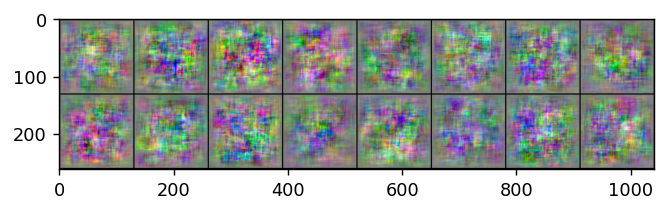

In [ ]:
# example before training
plt.rcParams['figure.dpi'] = 128
plt.grid(False)
z = torch.Tensor(batch_size, nz).normal_(0, 1).to(device)
g = G(z)
g_128, g_64 = g[0], g[1]  
plt.imshow(torchvision.utils.make_grid(g_128.add(1).mul(0.5)).clamp(0,1).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
def train_d_alt(net, data_real, data_fake, loss_funct = "dual contrastive"):
    pred_real , [rec_all, rec_small, rec_part], part = net(data_real, label="real")
    pred_fake = net(data_fake, label="fake")
    if loss_funct == "hinge":
        err = (F.relu(torch.rand_like(pred_real)*0.2 + 0.8 - pred_real) + F.relu(torch.rand_like(pred_real)*0.2 + 0.8 + pred_fake)).mean() + percept( rec_all, F.interpolate(data_real, rec_all.shape[2]) ).sum() +\
                        percept( rec_small, F.interpolate(data_real, rec_small.shape[2]) ).sum()
    elif loss_funct == "dual contrastive":
        err = dual_contrastive_loss( pred_fake, pred_real) +  percept( rec_all, F.interpolate(data_real, rec_all.shape[2]) ).sum() +\
                        percept( rec_small, F.interpolate(data_real, rec_small.shape[2]) ).sum()
    else: 
        print("INVALID LOSS FUNCTION, EITHER dual contrastive or hinge")
    err.backward()
    pred_item = pred_real.mean().item() + pred_fake.mean().item()
    return pred_item / 2

# dual contrastive loss as in: https://github.com/lucidrains/lightweight-gan
def dual_contrastive_loss(f_logits, r_logits):
    device = f_logits.device
    f_logits, r_logits = map(lambda t: rearrange(t, '... -> (...)'), (f_logits, r_logits))

    def loss_half(t1, t2):
        t1 = rearrange(t1, 'i -> i ()')
        t2 = repeat(t2, 'j -> i j', i = t1.shape[0])
        t = torch.cat((t1, t2), dim = -1)
        return F.cross_entropy(t, torch.zeros(t1.shape[0], device = device, dtype = torch.long))

    return loss_half(f_logits, r_logits) + loss_half(-r_logits, -f_logits)

**Main training loop**

In [ ]:
# training loop
loss_funct = "dual contrastive"
while (epoch<101):

    # iterate over some of the train dataset
    for i in range(1000): 

        # sample real images from the dataset
        real_images = next(train_iterator)
        real_images = real_images.to(device)

        # sample noise
        noise = torch.Tensor(batch_size, nz).normal_(0, 1).to(device)

        # create fake images
        with torch.no_grad():
            fake_images = G(noise)

        ## 2. train Discriminator
        D.zero_grad()

       
        err_dr = train_d_alt(D, real_images, [fi.detach() for fi in fake_images], loss_funct=loss_funct) 
        optimiser_D.step()
        
        ## 3. train Generator
        noise = torch.Tensor(batch_size, nz).normal_(0, 1).to(device)
        fake_images = G(noise)
        real_images = next(train_iterator)
        real_images = real_images.to(device)

        G.zero_grad()
        pred_g = D(fake_images, "fake")
        pred_g_real, _, _ = D(real_images, "real")
        
        if loss_funct == "dual contrastive":
            err_g = dual_contrastive_loss(pred_g_real, pred_g)
        elif loss_funct == "hinge":
            err_g = -pred_g.mean()

        err_g.backward()
        optimiser_G.step()

        # exponential moving average of weights
        for p, avg_p in zip(G.parameters(), avg_param_G):
            avg_p.mul_(0.999).add_(0.001 * p.data)

    # sample your model and plot some examples
    backup_para = copy_G_params(G)
    load_params(G, avg_param_G)
    load_params(G, backup_para)

    if epoch % 10 == 0:
        torch.save({'G':G.state_dict(), 'G_optimiser':optimiser_G.state_dict(), 'epoch':epoch, 'loss': (- err_g.item()), 'ema': avg_param_G}, 'drive/My Drive/Colab Notebooks/DL and RL/DL coursework/FastGAN/'+my_dataset+'G_' + str(epoch) + '.chkpt')
        torch.save({'D':D.state_dict(), 'D_optimiser':optimiser_D.state_dict(), 'epoch':epoch, 'loss':err_dr}, 'drive/My Drive/Colab Notebooks/DL and RL/DL coursework/FastGAN/'+my_dataset+'D_' +  str(epoch) + '.chkpt')
    
    with torch.no_grad():
        G.eval()
        z = torch.Tensor(8, nz).normal_(0, 1).to(device)
        g = G(z) 
        g_128, g_64 = g[0], g[1]
        print("Epoch: ", epoch)
        print('G_loss ', (- err_g.item()), 'D_loss ', err_dr)
        plt.rcParams['figure.dpi'] = 256
        plt.grid(False)
        plt.imshow(torchvision.utils.make_grid(g_128[:8].add(1).mul(0.5)).clamp(0,1).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
        plt.show()
        plt.pause(0.0001)
        G.train()

    epoch = epoch+1

In [ ]:
# optional example code to save your training progress for resuming later if you authenticated Google Drive previously
torch.save({'G':G.state_dict(), 'G_optimiser':optimiser_G.state_dict(), 'epoch':epoch, 'loss': (- err_g.item()), 'ema': avg_param_G}, 'drive/My Drive/Colab Notebooks/DL and RL/DL coursework/FastGAN/'+my_dataset+'G_' + str(epoch) + '.chkpt')
torch.save({'D':D.state_dict(), 'D_optimiser':optimiser_D.state_dict(), 'epoch':epoch, 'loss':err_dr}, 'drive/My Drive/Colab Notebooks/DL and RL/DL coursework/FastGAN/'+my_dataset+'D_' + str(epoch) + '.chkpt')

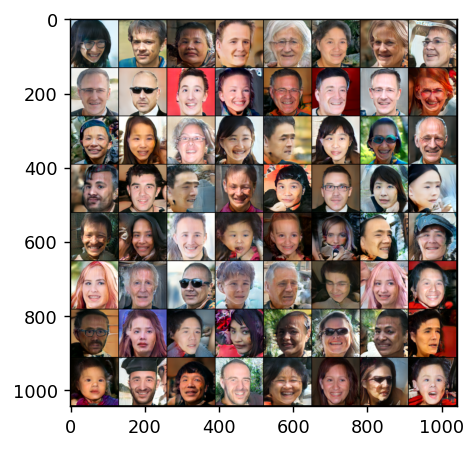

In [ ]:
# now show a batch of data for the submission, right click and save the image for your report
G.eval()
plt.rcParams['figure.dpi'] = 128
plt.grid(False)
z = torch.Tensor(64, nz).normal_(0, 1).to(device)
g = G(z)
g_128, g_64 = g[0], g[1]
G.train()
plt.imshow(torchvision.utils.make_grid(g_128.add(1).mul(0.5)).clamp(0,1).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

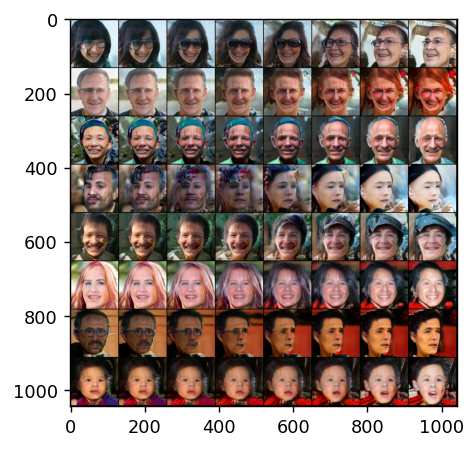

In [ ]:
from numpy.core.function_base import linspace

# linear interpolations
G.eval()
gri = list()
for c in range(8):
    col_start = c*8
    z0 = z[col_start] # first latent vector of column
    z1 = z[col_start + 7] # last latent vector of column
    multipliers = linspace(0, 1, num=8)
    for mul in multipliers:
        v = (1.0 - mul) * z0 + mul * z1
        gri.append(v)
    
gri = torch.stack(gri)

g = G(gri) 
g_128, g_64 = g[0], g[1]
plt.rcParams['figure.dpi'] = 128
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g_128.add(1).mul(0.5)).clamp(0,1).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()